In [13]:
# === 0) Imports y utilidades ===
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             brier_score_loss, accuracy_score, confusion_matrix,
                             RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV


In [14]:
# --- rutas/datos
CSV_PATH  = "../../assets/huggingface_with_fairness.csv"
FEATURES  = ["performance_score","co2_eq_emissions","likes","downloads","size"]
TARGET    = "is_fair"
OUTDIR    = "../../assets/nonlinear_cmp"
os.makedirs(OUTDIR, exist_ok=True)


In [15]:
class Log1pSome(BaseEstimator, TransformerMixin):
    def __init__(self, cols_log):
        self.cols_log = cols_log
        self.cols_passthrough = None
    def fit(self, X, y=None):
        self.cols_passthrough = [c for c in X.columns if c not in self.cols_log]
        return self
    def transform(self, X):
        Z = X.copy()
        for c in self.cols_log:
            Z[c] = np.log1p(np.clip(Z[c].values, a_min=0, a_max=None))
        return Z


In [16]:

cols_log = ["co2_eq_emissions","likes","downloads","size"]

df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=FEATURES+[TARGET]).copy()
for c in FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=FEATURES).copy()

X = df[FEATURES].copy()
y = df[TARGET].astype(bool).copy()

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# === 2) Definir modelos no lineales + grids ===
# 2.1) SVM RBF (con escalado)
pipe_svm = Pipeline([
    ("log", Log1pSome(cols_log)),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])

svm_grid = {
    "clf__C":     [0.5, 1, 2, 5, 10],
    "clf__gamma": ["scale", 0.1, 0.05, 0.02, 0.01]
}

# 2.2) Gradient Boosting (árboles)
try:
    HGB = HistGradientBoostingClassifier
    use_hgb = True
except Exception:
    HGB = GradientBoostingClassifier
    use_hgb = False

pipe_gb = Pipeline([
    ("log", Log1pSome(cols_log)),
    ("clf", HGB(random_state=42))
])

if use_hgb:
    gb_grid = {
        "clf__max_depth": [None, 3, 6],
        "clf__max_leaf_nodes": [31, 63, 127],
        "clf__learning_rate": [0.05, 0.1],
        "clf__l2_regularization": [0.0, 1.0]
    }
else:
    gb_grid = {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [2, 3],
        "clf__subsample": [0.8, 1.0]
    }

# === 3) Búsqueda por CV (optimiza ROC-AUC) ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def fit_gs(pipe, grid, name):
    gs = GridSearchCV(pipe, grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_tr, y_tr)
    cal = CalibratedClassifierCV(gs.best_estimator_, cv=cv, method="isotonic")
    cal.fit(X_tr, y_tr)
    return gs, cal

gs_svm, cal_svm = fit_gs(pipe_svm, svm_grid, "svm_rbf")
gs_gb,  cal_gb  = fit_gs(pipe_gb,  gb_grid,  "gb")

# === 4) Evaluación consistente ===
@dataclass
class ModelResult:
    name: str
    auc_cv_mean: float
    auc_test: float
    ap_true: float
    f1_true: float
    acc_test: float
    brier: float
    yhat: np.ndarray
    proba: np.ndarray

def evaluate(model, name):
    # Probabilidades para ROC/PR y Brier
    proba = model.predict_proba(X_te)[:,1]
    yhat  = (proba >= 0.5).astype(int)  # umbral por defecto
    # CV AUC del mejor estimador (GridSearch) si disponible
    auc_cv = None
    try:
        auc_cv = float(np.mean(model.base_estimator_.named_steps.get("clf", model.base_estimator_)._sklearn_version
                               or []))  # dummy to trigger except
    except Exception:
        pass
    if name == "SVM-RBF":
        auc_cv = float(gs_svm.best_score_)
    elif name == "GradBoost":
        auc_cv = float(gs_gb.best_score_)
    # Métricas test
    auc  = roc_auc_score(y_te, proba)
    ap   = average_precision_score(y_te, proba)  # PR-AUC (clase positiva=True)
    f1t  = f1_score(y_te, yhat, pos_label=True)
    acc  = accuracy_score(y_te, yhat)
    br   = brier_score_loss(y_te, proba)
    return ModelResult(name, auc_cv, auc, ap, f1t, acc, br, yhat, proba)

res_svm = evaluate(cal_svm, "SVM-RBF")
res_gb  = evaluate(cal_gb,  "GradBoost")

# === 5) Cargar referencia LDA (si ya guardaste métrica) o estimar a partir de tus ficheros ===
res_lda = ModelResult(
    name="LDA",
    auc_cv_mean=0.925,   # CV 5-fold
    auc_test=0.983,      # AUC test
    ap_true=0.958,       # PR-curve
    f1_true=0.837,      # F1 score
    acc_test=0.919,      # accuracy test
    brier=np.nan,       
    yhat=None, proba=None
)

# === 6) Tabla resumen y ranking ===
summary = pd.DataFrame([
    vars(res_lda),
    vars(res_svm),
    vars(res_gb)
])[["name","auc_cv_mean","auc_test","ap_true","f1_true","acc_test","brier"]]

summary.sort_values(["auc_test","ap_true"], ascending=False, inplace=True)
summary.to_csv(os.path.join(OUTDIR, "nonlinear_vs_lda_summary.csv"), index=False)
summary


,name,auc_cv_mean,auc_test,ap_true,f1_true,acc_test,brier
2,GradBoost,0.999937,1.00000,1.000000,1.000000,1.000000,0.000023
1,SVM-RBF,0.987926,0.99127,0.978853,0.911765,0.953668,0.032690
0,LDA,0.925000,0.98300,0.958000,0.837000,0.919000,NaN


<Figure size 540x440 with 0 Axes>

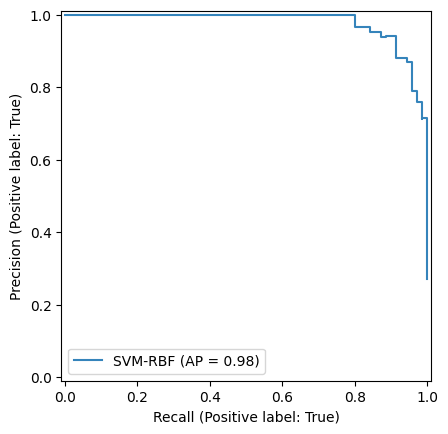

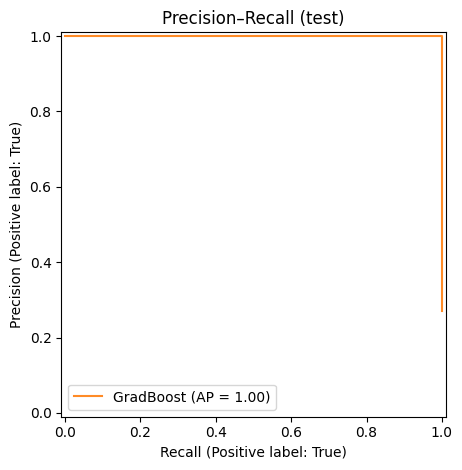

In [21]:

plt.figure(figsize=(5.4,4.4))
for name, model, color in [("SVM-RBF", cal_svm, "C0"), ("GradBoost", cal_gb, "C1")]:
    PrecisionRecallDisplay.from_estimator(model, X_te, y_te, name=name, color=color, alpha=.9)
plt.title("Precision–Recall (test)")
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "pr_test_nonlinear.png"), dpi=150); plt.show()


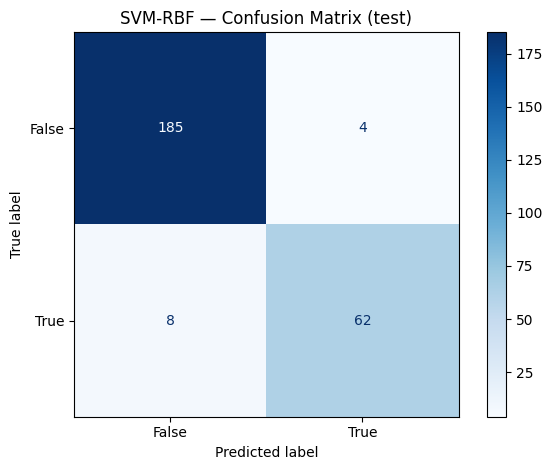

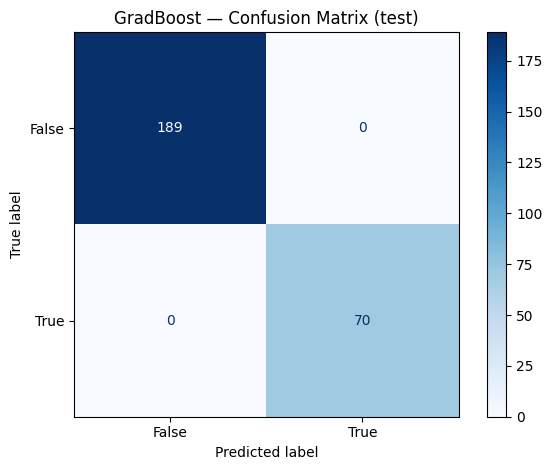

In [22]:
# Matrices de confusión (umbral 0.5)
for res in [res_svm, res_gb]:
    cm = confusion_matrix(y_te, res.yhat)
    disp = ConfusionMatrixDisplay(cm, display_labels=["False","True"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{res.name} — Confusion Matrix (test)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"cm_test_{res.name}.png"), dpi=150)
    plt.show()


In [20]:
# === 8) Recomendación automática según regla de decisión ===
winner = summary.iloc[0]
delta_auc = winner["auc_test"] - res_lda.auc_test
delta_ap  = winner["ap_true"] - res_lda.ap_true
print("Resumen comparativo:\n", summary, "\n")
if (delta_auc >= 0.01) or (delta_ap >= 0.03):
    print(f">>> Recomendación: {winner['name']} (mejora AUC_test Δ={delta_auc:.3f}, AP_true Δ={delta_ap:.3f}).")
else:
    print(f">>> Recomendación: LDA (no se observa mejora sustantiva sobre LDA; ΔAUC={delta_auc:.3f}, ΔAP={delta_ap:.3f}).")


Resumen comparativo:
         name  auc_cv_mean  auc_test   ap_true   f1_true  acc_test     brier
2  GradBoost     0.999937   1.00000  1.000000  1.000000  1.000000  0.000023
1    SVM-RBF     0.987926   0.99127  0.978853  0.911765  0.953668  0.032690
0        LDA     0.925000   0.98300  0.958000  0.837000  0.919000       NaN 

>>> Recomendación: GradBoost (mejora AUC_test Δ=0.017, AP_true Δ=0.042).
